In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

/Users/shuang/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from helper import *

## Load dataset

In [4]:
# Read in cars and notcars
cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)

Text(0.5,1,'Example not car image')

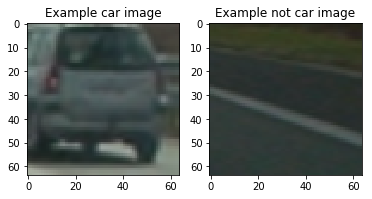

In [5]:
f, axes = plt.subplots(1, 2)
image_car = mpimg.imread(cars[3])
axes[0].imshow(image_car)
axes[0].set_title('Example car image')
image_noncar = mpimg.imread(notcars[300])
axes[1].imshow(image_noncar)
axes[1].set_title('Example not car image')

In [6]:
image_car.shape

(64, 64, 3)

## Generate features

### Color Histogram

Color Histogram of a Sample Car Image


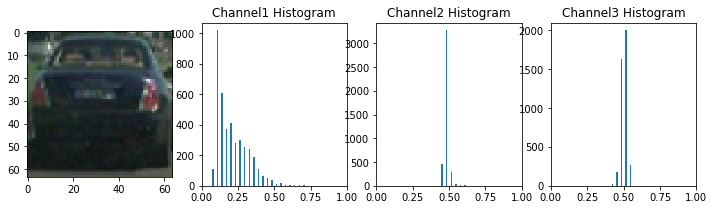

In [7]:
image_car = mpimg.imread(cars[800])
feature_image = convert_color(image_car, 'RGB', 'YUV')
bin_centers, hist_features = color_hist(feature_image, nbins=32, bins_range=(0,1), channels=[0,1,2])
print('Color Histogram of a Sample Car Image')
f, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(image_car)
axes[1].bar(bin_centers, hist_features[:32], 0.01)
axes[1].set_xlim(0, 1)
axes[1].set_title('Channel1 Histogram')
axes[2].bar(bin_centers, hist_features[32:64], 0.01)
axes[2].set_xlim(0, 1)
axes[2].set_title('Channel2 Histogram')
axes[3].bar(bin_centers, hist_features[64:], 0.01)
axes[3].set_xlim(0, 1)
axes[3].set_title('Channel3 Histogram')
plt.show()

Color Histogram of a Sample Non-Car Image


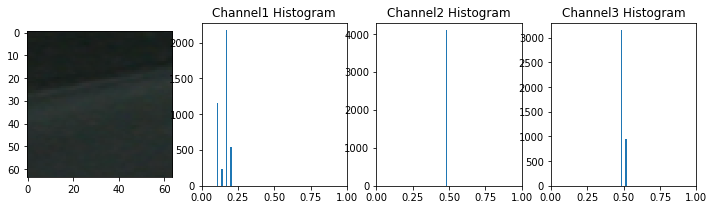

In [8]:
image_noncar = mpimg.imread(notcars[3500])
feature_image = convert_color(image_noncar, 'RGB', 'YUV')
bin_centers, hist_features = color_hist(feature_image, nbins=32, bins_range=(0,1))
print('Color Histogram of a Sample Non-Car Image')
f, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(image_noncar)
axes[1].bar(bin_centers, hist_features[:32], 0.01)
axes[1].set_xlim(0, 1)
axes[1].set_title('Channel1 Histogram')
axes[2].bar(bin_centers, hist_features[32:64], 0.01)
axes[2].set_xlim(0, 1)
axes[2].set_title('Channel2 Histogram')
axes[3].bar(bin_centers, hist_features[64:], 0.01)
axes[3].set_xlim(0, 1)
axes[3].set_title('Channel3 Histogram')
plt.show()

### Spatially binned color

In [11]:
image_noncar = mpimg.imread(notcars[30])
image_car = mpimg.imread(cars[370])
feature_image = convert_color(image_car, 'RGB', 'YUV')
car_spatial_features = bin_spatial(feature_image)
feature_image = convert_color(image_noncar, 'RGB', 'YUV')
noncar_spatial_features = bin_spatial(feature_image)


Text(0.5,1,'Noncar - Spatially Binned Features')

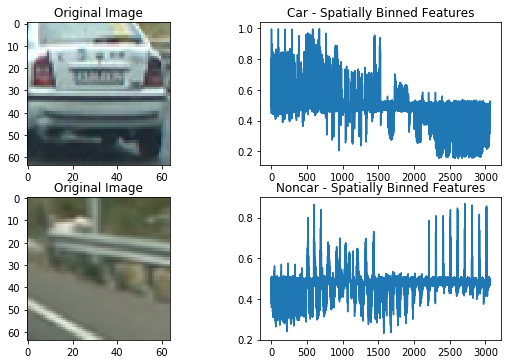

In [12]:
f, axes = plt.subplots(2, 2, figsize=(8, 5))
f.tight_layout()
axes[0][0].imshow(image_car)
axes[0][0].set_title('Original Image')
axes[0][1].plot(car_spatial_features)
axes[0][1].set_title('Car - Spatially Binned Features')
axes[1][0].imshow(image_noncar)
axes[1][0].set_title('Original Image')
axes[1][1].plot(noncar_spatial_features)
axes[1][1].set_title('Noncar - Spatially Binned Features')

### HOG features

In [51]:
image_car = mpimg.imread(cars[1150])
cimage = cv2.cvtColor(image_car, cv2.COLOR_RGB2YCrCb)
hog_features, hog_image = get_hog_features(cimage[:,:,0], orient=15, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)

Text(0.5,1,'HOG GRAY')

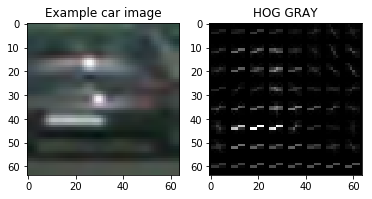

In [52]:
f, axes = plt.subplots(1, 2)
axes[0].imshow(image_car, cmap='gray')
axes[0].set_title('Example car image')
axes[1].imshow(hog_image, cmap='gray')
axes[1].set_title('HOG GRAY')

In [47]:
image_noncar = mpimg.imread(notcars[115])
cimage = cv2.cvtColor(image_noncar, cv2.COLOR_RGB2YCrCb)
hog_features, hog_image = get_hog_features(cimage[:,:,0], orient=11, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)

Text(0.5,1,'HOG GRAY')

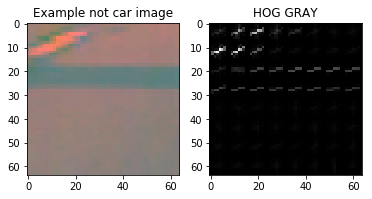

In [48]:
f, axes = plt.subplots(1, 2)
axes[0].imshow(cimage, cmap='gray')
axes[0].set_title('Example not car image')
axes[1].imshow(hog_image, cmap='gray')
axes[1].set_title('HOG GRAY')

## Combine Features

In [28]:
### TODO: Tweak these parameters and see how the results change.
parameters = {'color_space':'YUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
              'orient':15, # HOG orientations
              'pix_per_cell':8,# HOG pixels per cell
              'cell_per_block':2, # HOG cells per block
              'hog_channel': 'ALL',# Can be 0, 1, 2, or "ALL"
              'spatial_size': (32, 32), # Spatial binning dimensions
              'hist_bins': 32, # Number of histogram bins
              'spatial_feat': True, # Spatial features on or off
              'hist_feat': True, # Histogram features on or off
              'hog_feat': True} # HOG features on or off

In [54]:
car_features = extract_features(cars, **parameters)

/Users/shuang/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [55]:
notcar_features = extract_features(notcars, augment=False, **parameters)

/Users/shuang/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [56]:
print("Training dataset contains {} car images and {} non-car images.".format(len(car_features), len(notcar_features)))

Training dataset contains 8792 car images and 8968 non-car images.


In [57]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Samples in training set:', len(y_train))
print('Samples in testing set:', len(y_test))

print('Using:',parameters['orient'],'orientations',parameters['pix_per_cell'],
    'pixels per cell and', parameters['cell_per_block'],'cells per block')
print('Feature vector length:', len(X_train[0]))

Samples in training set: 14208
Samples in testing set: 3552
Using: 15 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 11988


## Train classifier

In [58]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
tic=time.time()
svc.fit(X_train, y_train)
toc = time.time()
print(round(toc-tic, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
print('My SVC predicts: ', svc.predict(X_test[0:10]))
print('For labels:      ', y_test[0:10])

9.12 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [1. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
For labels:       [1. 1. 0. 1. 0. 1. 1. 1. 1. 1.]


## Slide window search

In [59]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255
xy_windows =  [(96,96), (128,128), (256, 256)] 
y_start_stops = [[400, 600], [400, 700], [400,None]]
windows_all = []
for xy_window, y_start_stop in zip(xy_windows, y_start_stops):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=(0.75, 0.75))
    windows_all.extend(windows) 

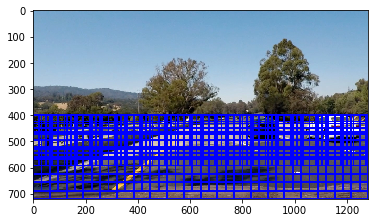

In [60]:
window_img = draw_boxes(draw_image, windows_all, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

/Users/shuang/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


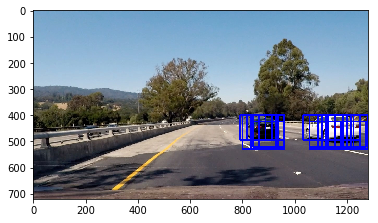

In [62]:
hot_windows = search_windows(image, windows_all, svc, X_scaler, **parameters)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

## Use Heatmap to remove false positive

In [63]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)  
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
labeled_img = draw_labeled_bboxes(draw_image, labels)

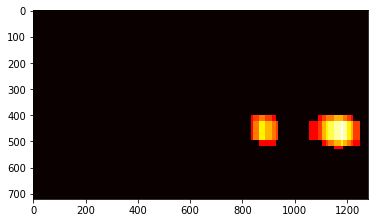

In [64]:
plt.imshow(heatmap, cmap='hot')

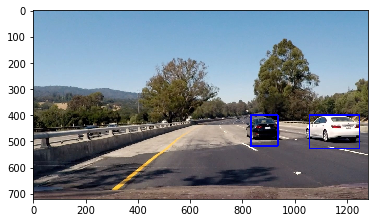

In [65]:
plt.imshow(labeled_img)

In [66]:
import pickle

In [67]:
with open(r"classifier.p", "wb") as output_file:
    pickle.dump(svc, output_file)

In [68]:
with open(r"scaler.p", "wb") as output_file:
    pickle.dump(X_scaler, output_file)

In [5]:
with open(r"classifier.p", "rb") as in_file:
    svc = pickle.load(in_file)

/Users/shuang/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LinearSVC from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
with open(r"scaler.p", "rb") as in_file:
    X_scaler = pickle.load(in_file)

/Users/shuang/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Put together a pipeline

### retrain the model with the same parameters but now with all the data

In [28]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
X = X_scaler.transform(X)
svc = LinearSVC()
svc.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [72]:
pipeline_parameters = dict(parameters, **{'X_scaler': X_scaler,'clf': svc})

In [75]:
pipeline_parameters

{'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'cell_per_block': 2,
 'clf': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0),
 'color_space': 'YUV',
 'hist_bins': 32,
 'hist_feat': True,
 'hog_channel': 'ALL',
 'hog_feat': True,
 'orient': 15,
 'pix_per_cell': 8,
 'spatial_feat': True,
 'spatial_size': (32, 32)}

In [78]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, clf, X_scaler, color_space, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins,hog_channel,
              spatial_feat, hist_feat, hog_feat):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]  # sub-sampling
    ctrans_tosearch = convert_color(img_tosearch, conv_from='RGB', conv_to='YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #nblocks_per_window = (window // pix_per_cell)-1 

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
   
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            _, hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_stacked)    
            #test_features = scaler.transform(np.array(features).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))

    return bboxes

In [ ]:
def detect_cars(image):
    bboxes = []
    ystart = 400
    ystop = 500 
    out_img, bboxes1 = find_cars(image, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 500 
    out_img, bboxes2 = find_cars(image, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 410
    ystop = 500 
    out_img, bboxes3 = find_cars(out_img, ystart, ystop, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556 
    out_img, bboxes4 = find_cars(out_img, ystart, ystop, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes5 = find_cars (out_img, ystart, ystop, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes6 = find_cars (out_img, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556 
    out_img, bboxes7 = find_cars (out_img, ystart, ystop, 1.9, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes8 = find_cars (out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes9 = find_cars (out_img, ystart, ystop, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 500 
    ystop = 656 
    out_img, bboxes10 = find_cars (out_img, ystart, ystop, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
   
   
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    threshold = 1 
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    current_heatmap = np.clip(heat, 0, 255)
    history.append(current_heatmap)
    
    heatmap = np.zeros_like(current_heatmap).astype(np.float)
    for heat in history:
        heatmap = heatmap + heat

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img
    

In [117]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def process_image(image, n_frame, n_threshold, **kwargs):
    global hot_windows_list
    draw_image = np.copy(image)
    
    search_windows = [(400, 500, 1), (400, 500, 1.2),(400, 500, 1.4), 
                      (420, 560, 1.3), (420, 560, 1.5), (420, 560, 1.8), 
                      (430, 560, 2), (400, 560, 2.2),
                      (400, 660, 2.5), (500, 660, 3)
                     ]
    boxes = []
    for window in search_windows:
        boxes.extend(find_cars(image, window[0], window[1], window[2], **pipeline_parameters)) 

    hot_windows_list.append(boxes)
    if len(hot_windows_list) > n_frame:
        hot_windows_list.pop(0)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for hot_windows in hot_windows_list:
        heat = add_heat(heat, hot_windows)
    
    heat = apply_threshold(heat, n_threshold)
 
    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    labeled_img = draw_labeled_bboxes(draw_image, labels)    
    
    return labeled_img

<Figure size 432x288 with 0 Axes>

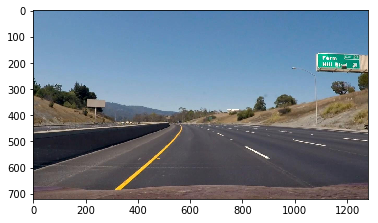

<Figure size 432x288 with 0 Axes>

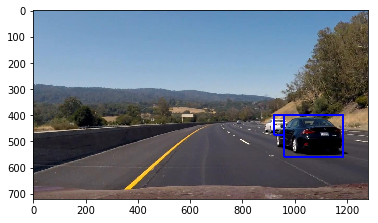

<Figure size 432x288 with 0 Axes>

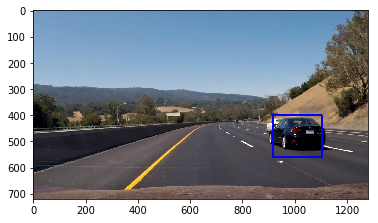

<Figure size 432x288 with 0 Axes>

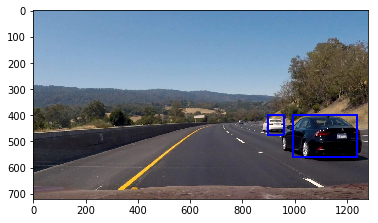

<Figure size 432x288 with 0 Axes>

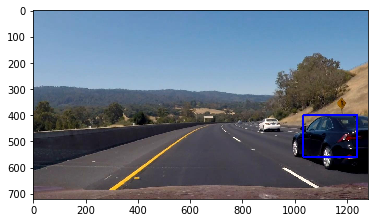

<Figure size 432x288 with 0 Axes>

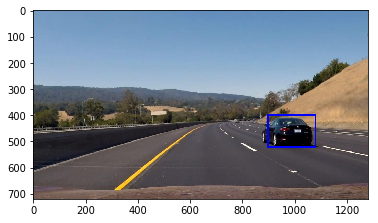

<Figure size 432x288 with 0 Axes>

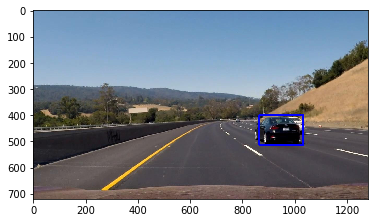

<Figure size 432x288 with 0 Axes>

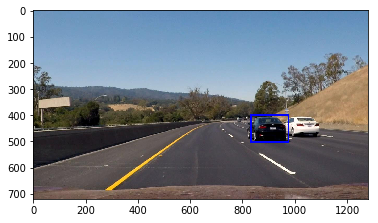

<Figure size 432x288 with 0 Axes>

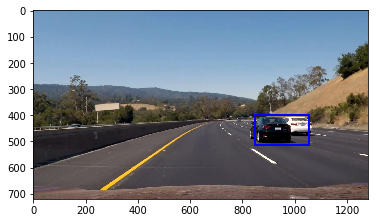

<Figure size 432x288 with 0 Axes>

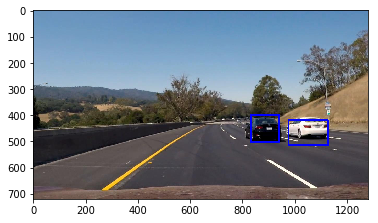

<Figure size 432x288 with 0 Axes>

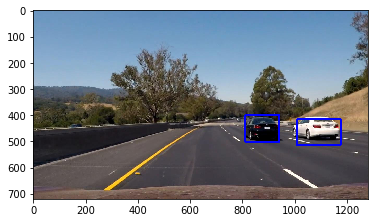

In [121]:
tests = glob.glob('test_images/project3*.jpg', recursive=True)
for file in tests:
    image = mpimg.imread(file)
    hot_windows_list=[]
    result = process_image(image, n_frame=1, n_threshold=1, **pipeline_parameters)
    plt.figure()    
    f, axe = plt.subplots()
    axe.imshow(result)
plt.show()

# from functools import partial

In [93]:
from functools import partial

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

hot_windows_list=[]
video = VideoFileClip("project_video.mp4", audio=False)#.subclip(5,8)

project_clip = video.fl_image(partial(process_image, n_frame=10, n_threshold=5, **pipeline_parameters))

output = "vehicle_detection.mp4"
%time project_clip.write_videofile(output, audio=False)